In [2]:
import sys
sys.path.append(r"/mnt/ceph/users/tudomlumleart/00_VirtualEnvironments/teeu/lib/python3.10/site-packages")
sys.path.append(r"/mnt/home/tudomlumleart/.local/lib/python3.10/site-packages/")
sys.path.append(r"/mnt/home/tudomlumleart/ceph/00_VirtualEnvironments/jupyter-gpu/lib/python3.10/site-packages")
from utils import *
from functions import *
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture 
import sklearn
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import validation_curve
import os
import pickle 
import re
import gc

os.environ['TF_ENABLE_ONEDNN_OPTS']='0'

from sklearn.metrics import adjusted_mutual_info_score

import os
import scipy.io


2024-08-30 14:00:16.370838: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-30 14:00:16.412388: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
from _polychrom import * 
def load_polymer_simulation(polymer_directory, num_monomers=None):
    items = os.listdir(polymer_directory)
    # Filter out the items that are not directories
    folders = [item for item in items if os.path.isdir(os.path.join(polymer_directory, item))]
    polymer_folders = [os.path.join(polymer_directory, f) for f in folders if f[:8] == 'template']

    def load_polymer_hdf5(polymer_directory, num_monomers):
        URIs = polychrom.hdf5_format.list_URIs(polymer_directory)
        if num_monomers is None:
            [num_monomers, _] = polychrom.hdf5_format.load_URI(URIs[0])["pos"].shape
        num_polymers = len(URIs)
        polys = np.full((num_monomers, 3, num_polymers), np.nan)
        dmaps = np.full((num_monomers, num_monomers, num_polymers), np.nan)
        for iURI, URI in enumerate(URIs):
            data = polychrom.hdf5_format.load_URI(URI)
            xyz = data["pos"]
            polys[:, :, iURI] = xyz[:num_monomers, :]
            dmaps[:, :, iURI] = squareform(pdist(xyz[:num_monomers, :]))
        return polys, dmaps

    polymer_folders.sort()

    polys_list, dmaps_list = [], []
    for f in polymer_folders:
        polys, dmaps = load_polymer_hdf5(f, num_monomers)
        polys_list.append(polys)
        dmaps_list.append(dmaps)
    
    polys_tensor = np.concatenate(polys_list, axis=2)
    dmaps_tensor = np.concatenate(dmaps_list, axis=2)
    
    return polys_tensor, dmaps_tensor 

sarw_directory = r'/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/SARW'
le_directory = r'/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/LoopExtrusion_NoBE'
hox_directory =  r'/mnt/home/tudomlumleart/ceph/01_TetheringSimulation/LoopExtrusion_HoxA/'
num_monomers = 100 # 333 monomers are too large - use too much memory

sarw_polys, sarw_dmaps = load_polymer_simulation(sarw_directory, num_monomers)
le_polys, le_dmaps = load_polymer_simulation(le_directory, num_monomers)
hox_polys, hox_dmaps = load_polymer_simulation(hox_directory, num_monomers)

In [116]:
contact_threshold = np.diag(np.median(hox_dmaps, axis=2), 1).mean()
print(contact_threshold)

1.0028969416144793


In [55]:
import random
sample_size = 20  # number of samples you want

# Ensure no repeated indices
chosen_indices = sorted(random.sample(range(num_monomers), sample_size))

In [102]:
chosen_indices = np.array([
    4, 6, 
    10, 19, 
    22, 23,
    35, 39,
    40, 43, 
    46, 50, 
    55, 59,
    60, 70,
    76, 77,
    80, 95,
    96, 99
])

In [70]:
num_chosen_indices = len(chosen_indices)

In [105]:
num_chosen_indices

22

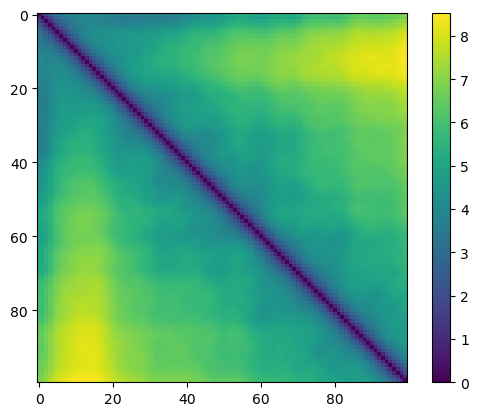

In [110]:
plt.imshow(np.median(hox_dmaps, axis=2))
plt.colorbar()

In [108]:
hox_dmaps[chosen_indices, chosen_indices, :].shape

(22, 5300)

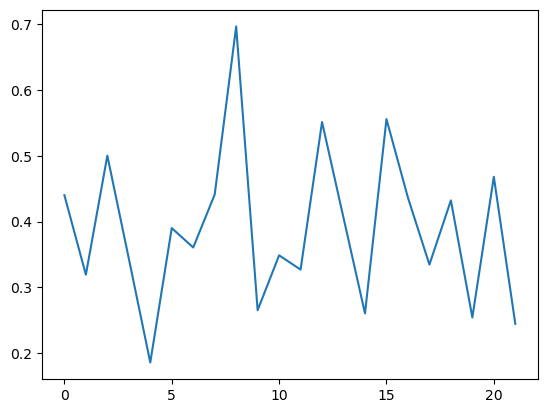

In [71]:
missing_data_prob = np.random.normal(0.4, 0.1, num_chosen_indices)
missing_data_prob[missing_data_prob < 0] = 0
missing_data_prob[missing_data_prob > 1] = 1
plt.plot(missing_data_prob)

In [72]:
def interpolate_polymers(polys):
    num_cells, num_probes, num_coords = polys.shape
    new_polys = np.zeros((num_cells, num_probes, num_coords))
    for c in range(num_cells):
        curr_cells = polys[c, :, :]
        for x in range(num_coords):
            curr_coords = curr_cells[:, x]
            missing_indices = np.isnan(curr_coords)
            valid_indices = ~missing_indices
            interp_coords = np.interp(np.flatnonzero(missing_indices), np.flatnonzero(valid_indices), curr_coords[valid_indices])
            new_polys[c, missing_indices, x] = interp_coords
            new_polys[c, valid_indices, x] = curr_coords[valid_indices]
    return new_polys

In [73]:
X = hox_polys[chosen_indices, :, :]
num_observations = X.shape[2]

observations_with_nan = np.array([squareform(pdist(X[:, :, x])) for x in range(num_observations)])
polys_with_nan = np.array([X[:, :, x] for x in range(num_observations)])
existing_data = np.zeros(observations_with_nan.shape)
# Randomly add nan to the dataset based on the missing_data_prob
for i in range(num_observations):
    missing_indices = np.random.uniform(size=num_chosen_indices) < missing_data_prob
    observations_with_nan[i, missing_indices, :] = np.nan
    observations_with_nan[i, :, missing_indices] = np.nan
    polys_with_nan[i, missing_indices, :] = np.nan
    existing_data[i, ~missing_indices, :] = 1
    existing_data[i, :, ~missing_indices] = 1
    
existing_data_flatten = np.array([x.flatten() for x in existing_data.astype(bool)])

observations_flatten_with_nan = np.array([x.flatten() for x in observations_with_nan])


In [74]:
mean_impute_polys = interpolate_polymers(polys_with_nan)
mean_impute_maps = [squareform(pdist(x)).flatten() for x in mean_impute_polys]

In [75]:
from sklearn.impute import KNNImputer

In [76]:
imputer = KNNImputer(weights='distance')

In [77]:
knn_impute_maps = imputer.fit_transform(observations_flatten_with_nan)

In [78]:
mean_impute_maps = np.array(mean_impute_maps)

In [79]:
observations_flatten = np.array([squareform(pdist(X[:, :, x])) for x in range(num_observations)])
observations_flatten = np.array([x.flatten() for x in observations_flatten])

In [80]:
knn_imp_error = np.linalg.norm(knn_impute_maps - observations_flatten)
mean_imp_error = np.linalg.norm(mean_impute_maps - observations_flatten)

In [81]:
knn_imp_error

2501.990947373048

In [82]:
mean_imp_error

2248.376764944449

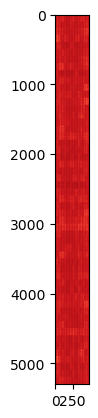

In [83]:
plt.imshow(knn_impute_maps, cmap='Reds_r')

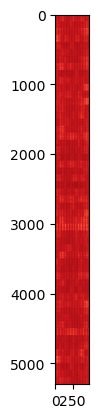

In [84]:
plt.imshow(mean_impute_maps, cmap='Reds_r')

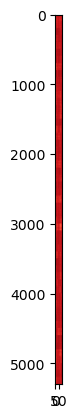

In [54]:
plt.imshow(observations_flatten, cmap='Reds_r')

In [113]:
X_maps = np.array([squareform(pdist(X[:, :, x])) for x in range(num_observations)])

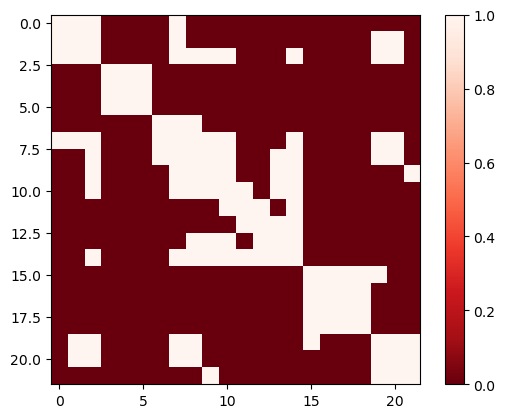

In [123]:
plt.imshow(X_maps[4, :, :] < 3, cmap='Reds_r')
plt.colorbar()

In [124]:
# How about predicting contact 
observations_flatten = np.array([squareform(pdist(X[:, :, x])) < 3 for x in range(num_observations)])
observations_flatten = np.array([x.flatten() for x in observations_flatten])

In [125]:
observations_flatten[0] == observations_flatten[1]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True, False,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True, False, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,

In [126]:
imputer = KNNImputer(weights='distance')
knn_impute_maps = imputer.fit_transform(observations_flatten_with_nan < contact_threshold)

In [127]:
mean_impute_polys = interpolate_polymers(polys_with_nan)
mean_impute_maps = np.array([squareform(pdist(x)).flatten() < contact_threshold for x in mean_impute_polys])

In [128]:
knn_imp_error = np.linalg.norm(knn_impute_maps.astype(int) - observations_flatten.astype(int))
mean_imp_error = np.linalg.norm(mean_impute_maps.astype(int) - observations_flatten.astype(int))

In [129]:
knn_imp_error

673.6215554745854

In [130]:
mean_imp_error

624.1746550445637